In [1]:
from gridworld import *
% matplotlib inline

# create the gridworld as a specific MDP
gridworld=GridMDP([[-0.04,-0.04,-0.04,1],[-0.04,None, -0.04, -1], [-0.04, -0.04, -0.04, -0.04]], terminals=[(3,2), (3,1)], gamma=1.)

example_pi = {(0,0): (0,1), (0,1): (0,1), (0,2): (1,0), (1,0): (1,0), (1,2): (1,0), (2,0): (0,1), (2,1): (0,1), (2,2): (1,0), (3,0):(-1,0), (3,1): None, (3,2):None}

example_q = {	((0,0),(-1,0)): 0.1,((0,0),(1,0)): 0.4,((0,0),(0,1)): 0.3,((0,0),(0,-1)): 0.2,
		((0,1),(-1,0)): 0.0,((0,1),(1,0)): 0.2,((0,1),(0,1)): 0.5,((0,1),(0,-1)): 0.1,
		((0,2),(-1,0)): 0.1,((0,2),(1,0)): 0.6,((0,2),(0,1)): 0.1,((0,2),(0,-1)): 0.0,
		((1,0),(-1,0)): 0.4,((1,0),(1,0)): 0.2,((1,0),(0,1)): 0.1,((1,0),(0,-1)): 0.2,
		((1,2),(-1,0)): 0.2,((1,2),(1,0)): 0.7,((1,2),(0,1)): 0.4,((1,2),(0,-1)): 0.3,
		((2,0),(-1,0)): 0.3,((2,0),(1,0)): -0.2,((2,0),(0,1)): 0.3,((2,0),(0,-1)): 0.1,
		((2,1),(-1,0)): 0.1,((2,1),(1,0)): -0.4,((2,1),(0,1)): 0.3,((2,1),(0,-1)): -0.1,
		((2,2),(-1,0)): 0.3,((2,2),(1,0)): 0.8,((2,2),(0,1)): 0.3,((2,2),(0,-1)): 0.3,
		((3,0),(-1,0)): 0.2,((3,0),(1,0)): -0.3,((3,0),(0,1)): -0.6,((3,0),(0,-1)): 0.2,
		((3,1), None): -0.8, ((3,2),None):0.9}

/home/martin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [16]:
"""
1)	Complete the function passive_td, which implements temporal-	
	difference learning for fixed policies. The function takes as input a 		
	policy, the MDP and returns as output the value function. 	
"""

def passive_td(pi, mdp, alpha = 0.05, n_trials = 500):
	V = dict([(s, 0) for s in mdp.states]) # initialize value function
	R, gamma = mdp.R, mdp.gamma
	for i in range(n_trials):
		state = (0,0)
		while True:		
			newstate = mdp.new_state(state, pi[state])
			V[state] = V[state]  + alpha*( R(state) + gamma* V[newstate] -V[state])	
			if newstate in mdp.terminals:
				V[newstate] = V[newstate]  + alpha*( R(newstate) -V[newstate]) 
				break
			state = newstate
	return V



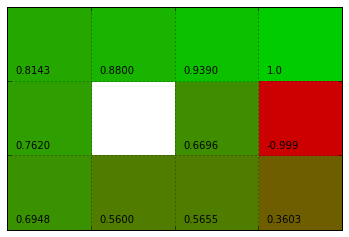

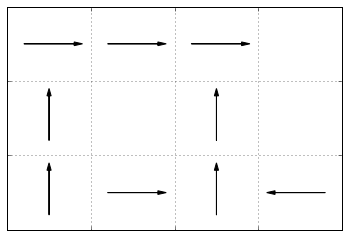

In [17]:
V=passive_td(example_pi, gridworld)
gridworld.v_plot(V)

In [4]:
"""
2)	Implement Q-learning in the function below and complete the function best_policy_q which 
	computes the best policy given a q-function. Compare the q-function you get with the q-function
	computed by value_iteration_q.	
"""

""" function argmax is needed for choosing the optimal action """
def argmax(seq, fn):
    best = seq[0]; best_score = fn(best)
    for x in seq:
        x_score = fn(x)
        if x_score > best_score:
            best, best_score = x, x_score
    return best


def q_learning(mdp, alpha = 0.1, n_trials=500):
	# initialize Q
	Q=dict([ ((s,a),0) for s in mdp.states for a in mdp.actions(s)])
	R, gamma = mdp.R, mdp.gamma	
	for i in range(n_trials):
		state = (0,0)
		while True:	
			action = argmax(mdp.actions(state), lambda a: Q[state,a])	# action selection	
			newstate = mdp.new_state(state, action)
			Q[state, action] = Q[state, action]  + alpha*( R(state) + gamma* max([Q[newstate,a] for a in mdp.actions(newstate)])-Q[state, action]) 	
			if newstate in mdp.terminals:
				Q[newstate, None] = Q[newstate, None]  + alpha*( R(newstate) -Q[newstate, None]) 
				break
			state = newstate
	return Q


def best_policy_q(mdp, Q):
    """Given an MDP and a q function, determine the best policy,
    as a mapping from state to action. """
    pi = {}
    for s in mdp.states:
        pi[s] = argmax(mdp.actions(s), lambda a: Q[s, a])
    return pi


def value_iteration_q(mdp, epsilon=0.0001):
    "Computing the q-function by value iteration. This assumes the transition model is known"
    Q1=dict([ ((s,a),0) for s in mdp.states for a in mdp.actions(s)]) # initialize value function
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    while True:
        Q = Q1.copy()
        delta = 0
        for s in mdp.states:
	    for a in mdp.actions(s):	
            	Q1[s,a] = R(s) + gamma * sum([p * max([Q[s1,a1] for a1 in mdp.actions(s1)])  for (p, s1) in T(s, a)])
            	delta = max(delta, abs(Q1[s,a] - Q[s,a]))
        if delta < epsilon:
             return Q

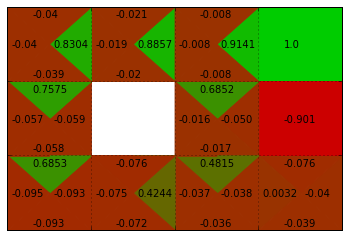

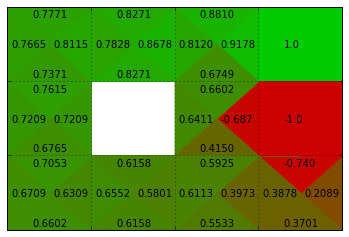

In [5]:
Q = q_learning(gridworld)
Qval = value_iteration_q(gridworld)
gridworld.q_plot(Q)
gridworld.q_plot(Qval)



In [6]:

"""
3)	Modify the function Q-learning so that it implements an epsilon-greedy agent.
"""

def epsilon_q_learning(mdp, epsilon, alpha = 0.1, n_trials=500):
	# initialize Q
	Q=dict([ ((s,a),0) for s in mdp.states for a in mdp.actions(s)])
	R, gamma = mdp.R, mdp.gamma	
	for i in range(n_trials):
		state = (0,0)
		while True:	
			# action selection
			if random.uniform(0,1)>epsilon:	
				action = argmax(mdp.actions(state), lambda a: Q[state,a])
			else:	
				action = random.choice(mdp.actions(state))
			newstate = mdp.new_state(state, action)
			Q[state, action] = Q[state, action]  + alpha*( R(state) + gamma* max([Q[newstate,a] for a in mdp.actions(newstate)])-Q[state, action]) 
			if newstate in mdp.terminals:
				Q[newstate, None] = Q[newstate, None]  + alpha*( R(newstate) -Q[newstate, None]) 
				break
			state = newstate
	return Q


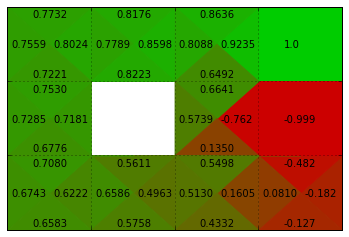

In [7]:
Qeps = epsilon_q_learning(gridworld, 0.5)
gridworld.q_plot(Qeps)